In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [3]:
f(3.0)

20.0

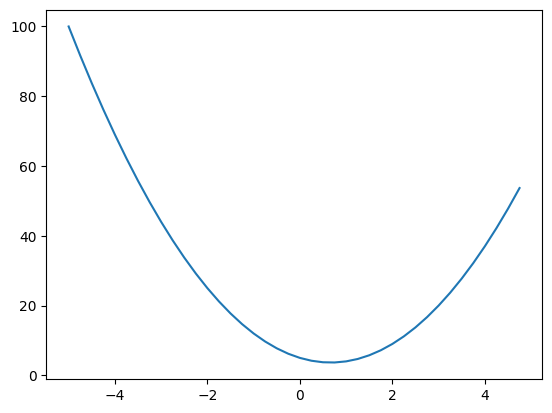

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2 / 3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [8]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [9]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h

d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [10]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supportinng int/float for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += (out.data * out.grad)

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [11]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [12]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this is a result of some operation, make a op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [13]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias b
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

o.backward()

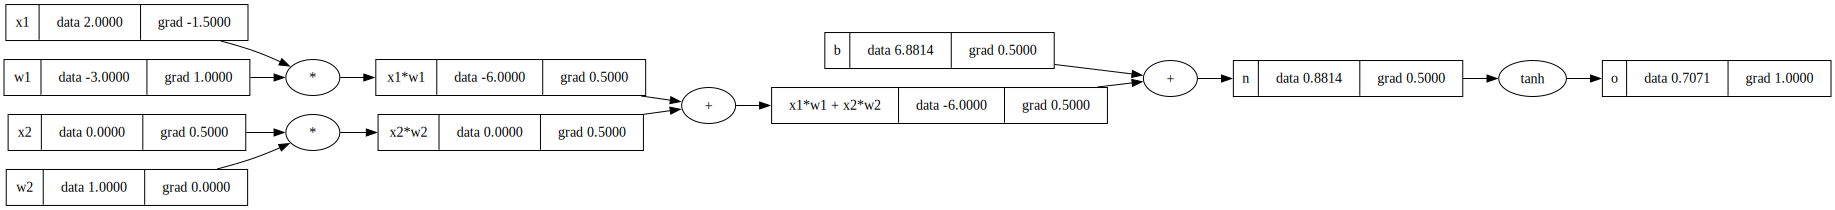

In [14]:
draw_dot(o)

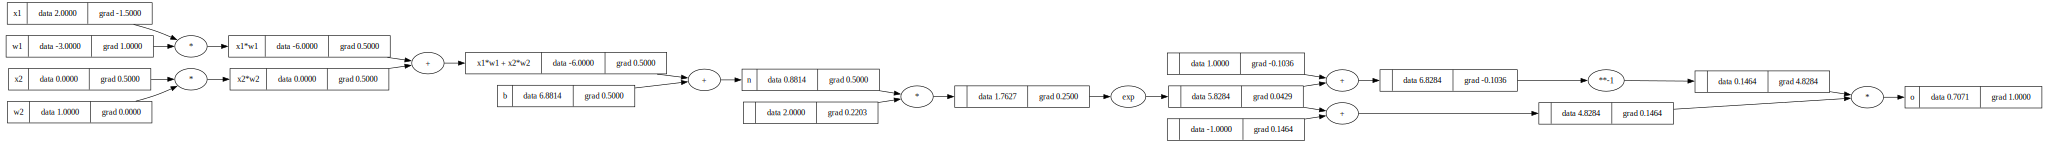

In [15]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias b
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"

e = (2 * n).exp()
o = (e - 1) / (e + 1)

o.label = "o"

o.backward()

draw_dot(o)

In [16]:
import torch

In [17]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x1", x1.grad.item())
print("w1", w1.grad.item())
print("x2", x2.grad.item())
print("w2", w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [18]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [ p for neuron in self.neurons for p in neuron.parameters() ]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [19]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.17269777400807576)

In [20]:
n.parameters()

[Value(data=0.8870178401288318),
 Value(data=0.02157753125034967),
 Value(data=0.22828199091675905),
 Value(data=0.08118951791470463),
 Value(data=0.3194604048990555),
 Value(data=0.40652095131801347),
 Value(data=0.2807074627579751),
 Value(data=-0.24182821629672846),
 Value(data=0.41711907386280433),
 Value(data=0.14623166874495785),
 Value(data=-0.6584942817461037),
 Value(data=0.919737503591314),
 Value(data=0.8308740399948948),
 Value(data=0.320379035716863),
 Value(data=-0.4190051813229487),
 Value(data=-0.8070461825230537),
 Value(data=0.2969473909654812),
 Value(data=-0.7309846458625009),
 Value(data=-0.7799188354919022),
 Value(data=0.8208344833968899),
 Value(data=-0.42285215568302803),
 Value(data=-0.5764300209133228),
 Value(data=-0.9743018367384357),
 Value(data=-0.2918380838025585),
 Value(data=-0.5821517382215529),
 Value(data=0.34287036289380945),
 Value(data=-0.7116048028874682),
 Value(data=0.15150449757898476),
 Value(data=-0.48203240445889795),
 Value(data=0.3493763

In [21]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0,-1.0,1.0]

In [23]:
for k in range(50):
    # forward pass
    ypred = [ n(x) for x in xs ]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k,loss.data)

0 0.007820103490129333
1 0.007648784944642588
2 0.007484695475272854
3 0.007327389203859924
4 0.007176456109466366
5 0.007031518497887017
6 0.0068922278801110525
7 0.0067582622055192155
8 0.0066293234036616955
9 0.006505135195200582
10 0.006385441138252202
11 0.00627000288112018
12 0.00615859859642512
13 0.006051021575037407
14 0.005947078961108316
15 0.005846590611954864
16 0.005749388068658005
17 0.00565531362503294
18 0.0055642194841796985
19 0.005475966993152742
20 0.005390425947439114
21 0.005307473957930385
22 0.0052269958739354526
23 0.005148883256532452
24 0.0050730338972111814
25 0.004999351377327742
26 0.004927744664392099
27 0.004858127741646646
28 0.004790419267777524
29 0.004724542263938344
30 0.004660423825563887
31 0.004597994856713245
32 0.004537189824915491
33 0.00447794653469569
34 0.004420205918142449
35 0.0043639118410399875
36 0.004309010923232472
37 0.0042554523720169995
38 0.004203187827476409
39 0.004152171218766051
40 0.004102358630460344
41 0.00405370817814762

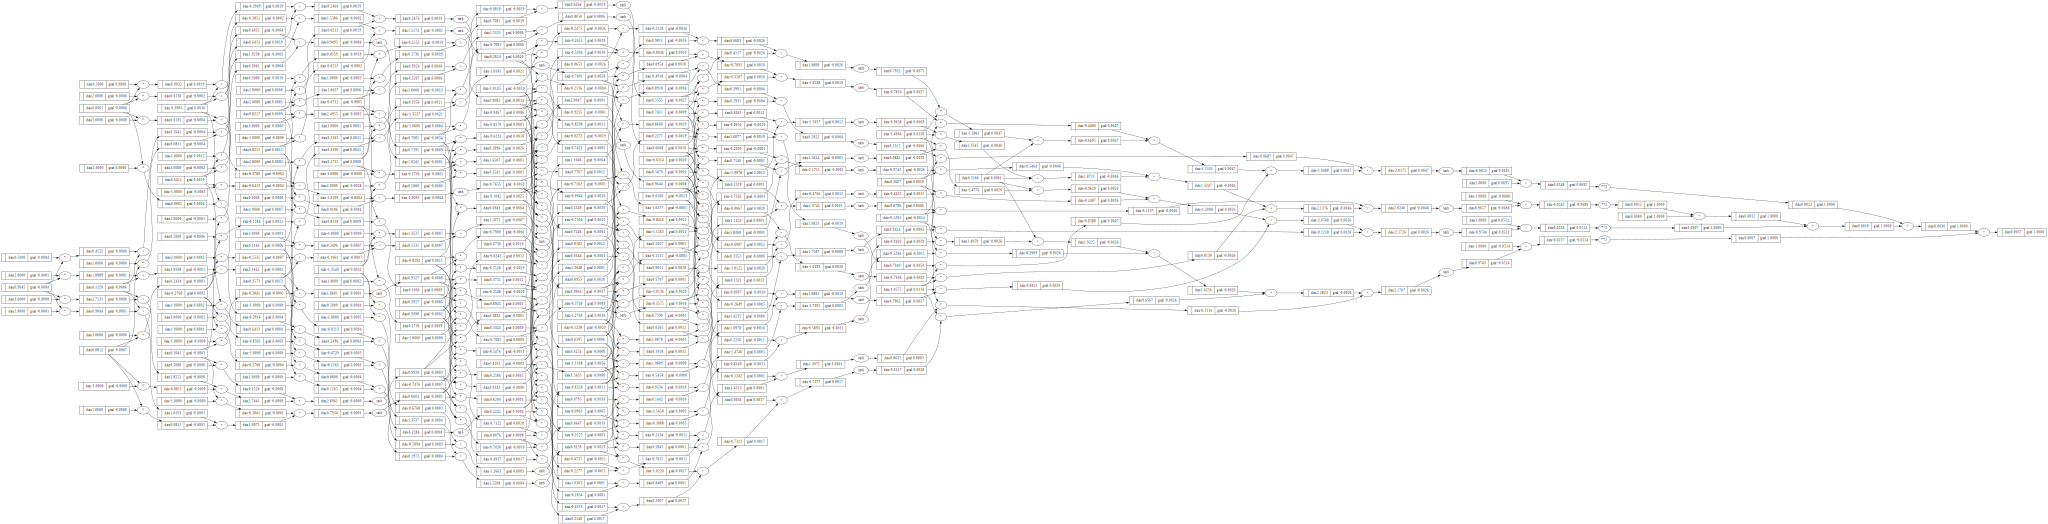

In [24]:
draw_dot(loss)